## setup

In [452]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [453]:
file_path = "detailed_analysis.jsonl"
depth = 32

## function

In [454]:
def read_jsonl_file(file_path):
    data_list = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            json_object = json.loads(line)
            data_list.append(json_object)
  
    return data_list

In [455]:
def pre_processing(sample_list, depth, types='full'):
    X_Accept = []
    Y_Accept = []
    X_Reject = []
    Y_Reject = []

    total_count = 0
    count = 0

    for sample in sample_list:
        for data in sample:
            # cut samples deeper than specified depth
            data[0] = data[0][:depth]
            data[1] = min(data[1], depth)
            total_count += 1
            if len(data[0]) == data[1]:
                count += 1
                if types == 'skip32':
                    continue
                # Accept all
                X_Accept.extend(data[0])
                Y_Accept.extend(range(1, data[1]+1))
            else:
                # Accept up to data[1], reject data[1]+1
                X_Accept.extend(data[0][:data[1]])
                Y_Accept.extend(range(1, data[1]+1))
                X_Reject.append(data[0][data[1]])
                Y_Reject.append(data[1]+1)

    print(f"Acceptance Rate: {count}/{total_count} = {count/total_count:.2%}")

    return X_Accept, Y_Accept, X_Reject, Y_Reject

In [456]:
def draw_scatter_plot(X_Accept, Y_Accept, X_Reject, Y_Reject):
    plt.figure(figsize=(20, 6))

    plt.scatter(X_Accept, Y_Accept, color='blue', label='Accept', s=20, alpha=0.4)
    plt.scatter(X_Reject, Y_Reject, color='red', label='Reject', s=20, alpha=0.4)

    plt.xlim(0.3, 1)
    plt.xticks(np.arange(0.3, 1.1, 0.1))
    plt.ylim(0.5, depth+0.5)
    plt.yticks(np.arange(1.0, depth+1, 2.0))

    plt.xlabel('Probability')
    plt.ylabel('Depth')
    plt.title('Scatter Plot of Depth vs Probability')
    plt.legend()

    plt.show()

In [457]:
def draw_histogram_prob(X_Accept, X_Reject):
    plt.figure(figsize=(10, 6))

    bin_edges = np.arange(0.0, 1.1, 0.1)

    X_Total = X_Accept + X_Reject
    total_count, _ = np.histogram(X_Total, bins=bin_edges)
    accept_count, _ = np.histogram(X_Accept, bins=bin_edges)
    reject_count, _ = np.histogram(X_Reject, bins=bin_edges)
    accept_normalized = accept_count / total_count
    reject_normalized = reject_count / total_count
    
    plt.bar(bin_edges[:-1], accept_normalized, width=0.1, color='blue', alpha=0.5, label='Accept', align='edge')
    plt.bar(bin_edges[:-1], reject_normalized, width=0.1, color='red', alpha=0.5, label='Reject', align='edge', bottom=accept_normalized)

    plt.xlim(0, 1)
    plt.xticks(np.arange(0.0, 1.1, 0.1))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Probability')
    plt.ylabel('Sample Proportion')
    plt.title('Probability Distribution by Acceptance Status')
    plt.legend()

    plt.show()

In [466]:
def draw_histogram_depth(Y_Accept, Y_Reject, depth):
    plt.figure(figsize=(10, 6))

    bin_edges = np.arange(0.5, depth+0.5, 1.0)

    Y_Total = Y_Accept + Y_Reject
    
    total_count, _ = np.histogram(Y_Total, bins=bin_edges)
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    reject_count, _ = np.histogram(Y_Reject, bins=bin_edges)
    accept_normalized = accept_count / total_count
    reject_normalized = reject_count / total_count

    plt.bar(bin_edges[:-1], accept_normalized, width=1.0, color='blue', alpha=0.5, label='Accept', align='edge')
    plt.bar(bin_edges[:-1], reject_normalized, width=1.0, color='red', alpha=0.5, label='Reject', align='edge', bottom=accept_normalized)

    plt.xlim(0.5, depth-0.5)
    plt.xticks(np.arange(1, depth, 2))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Depth')
    plt.ylabel('Sample Proportion')
    plt.title('Depth Distribution by Acceptance Status')
    plt.legend()

    plt.show()

In [467]:
def draw_histogram_cumulative_depth(Y_Accept, Y_Reject, depth):
    plt.figure(figsize=(10, 6))

    bin_edges = np.arange(0.5, depth+1.5, 1.0)

    Y_Total = Y_Accept + Y_Reject
    
    total_count, _ = np.histogram(Y_Total, bins=bin_edges)
    accept_count, _ = np.histogram(Y_Accept, bins=bin_edges)
    reject_count, _ = np.histogram(Y_Reject, bins=bin_edges)
    accept_normalized = accept_count / total_count
    for i in range(1, len(accept_normalized)):
        accept_normalized[i] *= accept_normalized[i-1]
    reject_normalized = 1 - accept_normalized

    plt.bar(bin_edges[:-1], accept_normalized, width=1.0, color='blue', alpha=0.5, label='Accept', align='edge')
    plt.bar(bin_edges[:-1], reject_normalized, width=1.0, color='red', alpha=0.5, label='Reject', align='edge', bottom=accept_normalized)

    plt.xlim(0.5, depth+0.5)
    plt.xticks(np.arange(1, depth+1, 2))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0.0, 1.1, 0.1))

    plt.xlabel('Depth')
    plt.ylabel('Sample Proportion')
    plt.title('Cumulative Depth Distribution by Acceptance Status')
    plt.legend()

    plt.show()

In [468]:
def draw_heatmap(X_Accept, Y_Accept, X_Reject, Y_Reject, depth):
    plt.figure(figsize=(10, 6), facecolor='white')

    prob_bins = np.arange(0.0, 1.1, 0.05)
    depth_bins = np.arange(1.0, depth+1.0, 1.0)

    # compute 2D histograms
    Count_Accept, _, _ = np.histogram2d(X_Accept, Y_Accept, bins=[prob_bins, depth_bins])
    Count_Reject, _, _ = np.histogram2d(X_Reject, Y_Reject, bins=[prob_bins, depth_bins])

    Count_Accept = Count_Accept.T
    Count_Reject = Count_Reject.T
    Total_Count = Count_Accept + Count_Reject

    max_count = np.amax(Total_Count)
    norm_intensity = Normalize(vmin=0, vmax=np.log1p(max_count))
    Intensity_Accept = norm_intensity(np.log1p(Count_Accept))
    Intensity_Reject = norm_intensity(np.log1p(Count_Reject))
    
    # plot heatmap
    N, M = Count_Accept.shape
    rgb_image = np.ones((N, M, 3))
    rgb_image[:, :, 0] = 1.0 - Intensity_Reject
    rgb_image[:, :, 1] = 1.0 - (Intensity_Accept + Intensity_Reject) / 2.0
    rgb_image[:, :, 2] = 1.0 - Intensity_Accept

    plt.imshow(
        rgb_image, 
        interpolation='nearest',
        origin='lower' 
    )

    tick_locations_x = np.arange(len(prob_bins) - 1)[::4] 
    all_prob_labels = [f"{x:.2f}" for x in prob_bins[:-1]] 
    tick_labels_x = all_prob_labels[::4]
    plt.xticks(tick_locations_x, tick_labels_x)

    tick_locations_y = np.arange(len(depth_bins) - 1)
    tick_labels_y = [f"{i:.0f}" for i in depth_bins[:-1]]
    plt.yticks(tick_locations_y, tick_labels_y)

    plt.xlabel('Probability')
    plt.ylabel('Depth')
    plt.title('Heatmap of Depth vs Probability')
    plt.show()

## Main

Acceptance Rate: 397/1122 = 35.38%


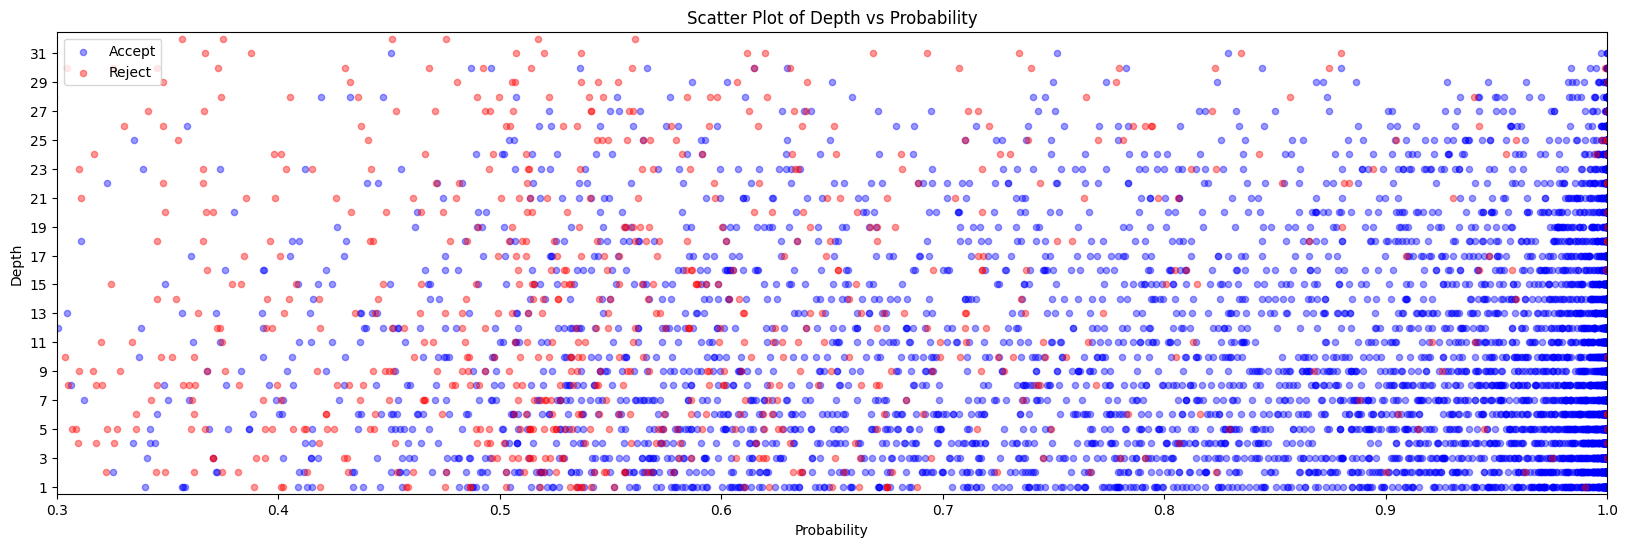

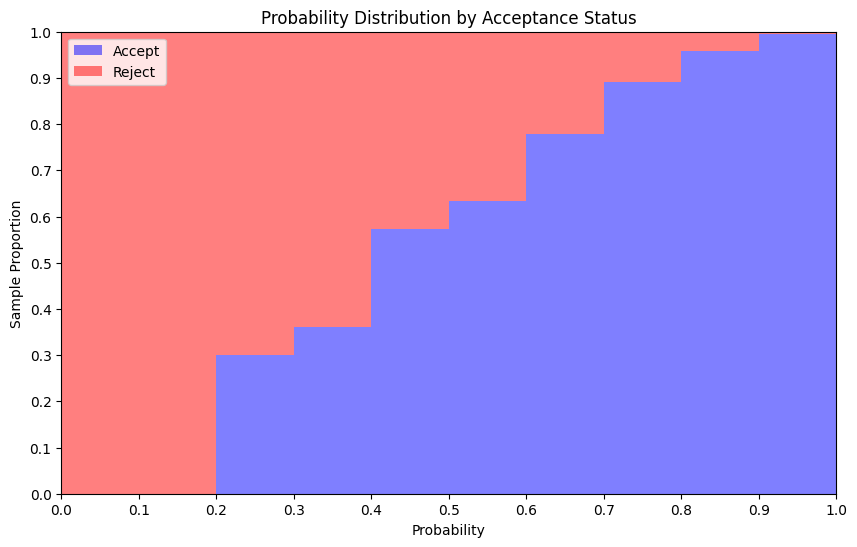

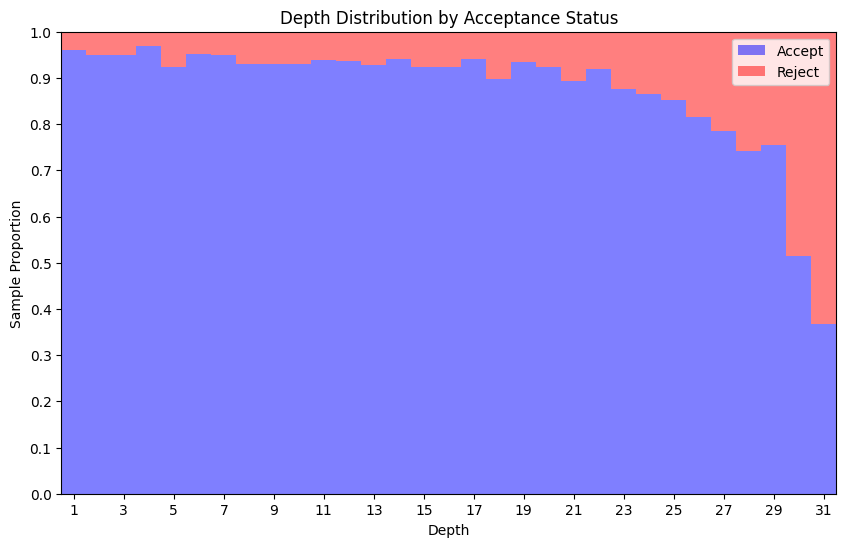

Acceptance Rate: 397/1122 = 35.38%


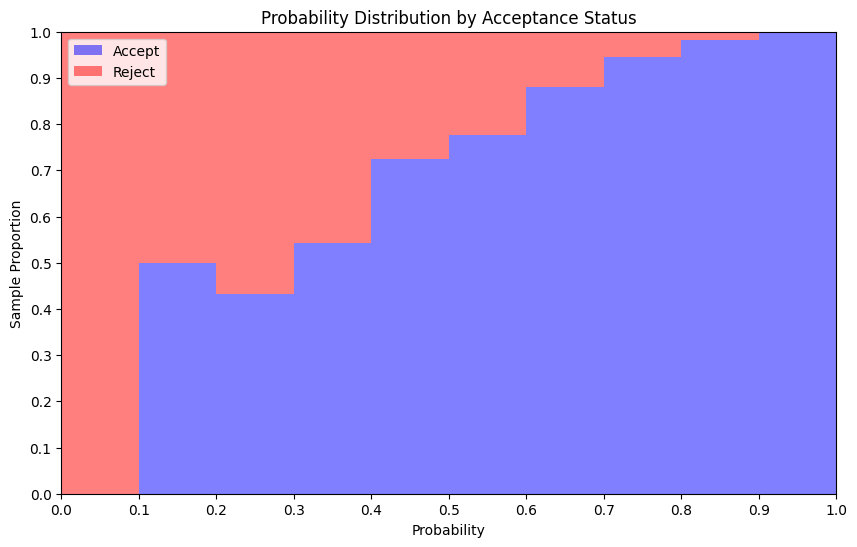

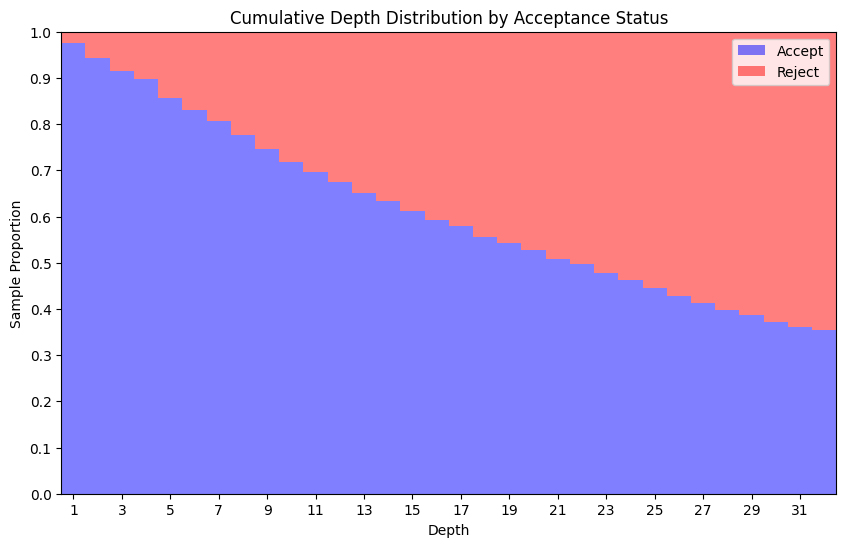

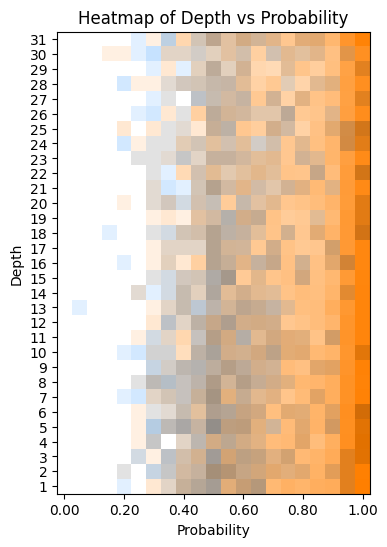

In [ ]:
sample_list = read_jsonl_file(file_path)

# X: Probability, Y: Depth
X_Accept, Y_Accept, X_Reject, Y_Reject = pre_processing(sample_list, depth, types='skip32')
draw_scatter_plot(X_Accept, Y_Accept, X_Reject, Y_Reject)
draw_histogram_prob(X_Accept, X_Reject)
draw_histogram_depth(Y_Accept, Y_Reject, depth)

X_Accept, Y_Accept, X_Reject, Y_Reject = pre_processing(sample_list, depth, types='full')
draw_histogram_prob(X_Accept, X_Reject)
draw_histogram_cumulative_depth(Y_Accept, Y_Reject, depth)
draw_heatmap(X_Accept, Y_Accept, X_Reject, Y_Reject, depth)